In [8]:
!pip install feast
!pip install matplotlib
!pip install mysql-connector-python
!pip install scikit-learn
!pip install mlflow
!pip install pycaret

  Using cached click-7.1.2-py2.py3-none-any.whl (82 kB)
  Attempting uninstall: Click
    Found existing installation: click 8.1.3
    Uninstalling click-8.1.3:
      Successfully uninstalled click-8.1.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 2.2.3 requires click>=8.0, but you have click 7.1.2 which is incompatible.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
  Using cached click-8.1.3-py3-none-any.whl (96 kB)
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
feast 0.12.1 requires Click==7.*, but you have click 8.1.3 which is incompatible.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [10]:
import numpy as np
from numpy import array
import os
import requests
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
import mysql.connector
import mlflow
import pycaret
from pycaret import classification as pyc



In [52]:
# Conexión a la base de datos
db = mysql.connector.connect(
  host="db_raw_data",
  user="root",
  password="123456",
  database="db_raw_data",
)
cursor = db.cursor()
# Consulta a la base de datos
cursor.execute("SELECT * FROM raw_table")
data = cursor.fetchall()
df = pd.DataFrame(data, columns=[col[0] for col in cursor.description])

In [53]:
from pycaret.classification import *
import numpy as np
import mlflow
import os

os.environ['MLFLOW_S3_ENDPOINT_URL'] = "http://10.43.102.113:9000"#creo que aca podemos poner minio
os.environ['AWS_ACCESS_KEY_ID'] = 'admin'
os.environ['AWS_SECRET_ACCESS_KEY'] = 'supersecret'

# connect to mlflow
mlflow.set_tracking_uri("http://10.43.102.113:5000")
mlflow.set_experiment("TallerFinal")

mlflow.autolog(log_model_signatures=True, log_input_examples=True)

2023/05/29 03:41:40 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/05/29 03:41:40 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of statsmodels. If you encounter errors during autologging, try upgrading / downgrading statsmodels to a supported version, or try upgrading MLflow.
2023/05/29 03:41:40 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


In [54]:
# Eliminar columnas no utilizadas
df = df.drop("weight", axis=1)

# Reemplazar los valores '?' por NaN
df = df.replace('?', pd.NaT)

# Eliminar filas con valores faltantes (NaN)
df = df.dropna()

In [55]:
categorical_columns = [
    'race',
    'gender',
    'age',
    'payer_code',
    'medical_specialty',
    'diag_1',
    'diag_2',
    'diag_3',
    'max_glu_serum',
    'A1Cresult',
    'metformin',
    'repaglinide',
    'nateglinide',
    'chlorpropamide',
    'glimepiride',
    'acetohexamide',
    'glipizide',
    'glyburide',
    'tolbutamide',
    'pioglitazone',
    'rosiglitazone',
    'acarbose',
    'miglitol',
    'troglitazone',
    'tolazamide',
    'examide',
    'citoglipton',
    'insulin',
    'glyburide_metformin',
    'glipizide_metformin',
    'glimepiride_pioglitazone',
    'metformin_rosiglitazone',
    'metformin_pioglitazone',
    'change_status',
    'diabetesMed',
]

# Realizar one-hot encoding en el DataFrame original
df = pd.get_dummies(df, columns=categorical_columns)

# Converir la variable objetivo a codificación ordinal
df['readmitted'] = df['readmitted'].map({'NO': 0, '>30': 1, '<30': 2})

In [56]:
df_infer = df.loc[100:100]
df = df.drop(100)

In [57]:
from pycaret.classification import *
s = pyc.setup(df, 
              target = 'readmitted',
              session_id=42,#
              fix_imbalance = True,#
              fix_imbalance_method= 'smote',#
              normalize = True,#
              transformation = True,#
              log_experiment = True,
              experiment_name = 'TallerFinal')

2023/05/29 03:41:49 INFO mlflow.tracking.fluent: Autologging successfully enabled for lightgbm.
2023/05/29 03:41:51 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'f7bc7bdbe85346b887f76511e9faadc3', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/05/29 03:41:51 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2023/05/29 03:41:51 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not specify a `predict` function, which is required in order to infer the signature
2023/05/29 03:41:51 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/05/29 03:41:55 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '6a04327b2e6

,Description,Value
0,Session id,42
1,Target,readmitted
2,Target type,Multiclass
3,Original data shape,"(14982, 1690)"
4,Transformed data shape,"(22303, 1690)"
5,Transformed train set shape,"(17808, 1690)"
6,Transformed test set shape,"(4495, 1690)"
7,Numeric features,1689
8,Preprocess,True
9,Imputation type,simple


In [24]:
# compare all models
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.6147,0.7000,0.6147,0.5773,0.5734,0.2287,0.2451,35.5160
lightgbm,Light Gradient Boosting Machine,0.6133,0.7036,0.6133,0.5777,0.5793,0.2412,0.2507,9.1980
rf,Random Forest Classifier,0.6005,0.6676,0.6005,0.5748,0.5399,0.1705,0.1957,11.7670
et,Extra Trees Classifier,0.5953,0.6570,0.5953,0.5548,0.5409,0.1692,0.1893,7.6610
ada,Ada Boost Classifier,0.5903,0.6621,0.5903,0.5534,0.5589,0.2037,0.2096,6.6220
lda,Linear Discriminant Analysis,0.5790,0.6341,0.5790,0.5319,0.5453,0.1765,0.1832,12.0300
ridge,Ridge Classifier,0.5696,0.0000,0.5696,0.5217,0.5330,0.1520,0.1600,4.8060
lr,Logistic Regression,0.5663,0.6211,0.5663,0.5317,0.5435,0.1738,0.1775,20.1080
dummy,Dummy Classifier,0.5660,0.5000,0.5660,0.3203,0.4091,0.0000,0.0000,7.6210
svm,SVM - Linear Kernel,0.5377,0.0000,0.5377,0.5144,0.5237,0.1410,0.1422,11.8380


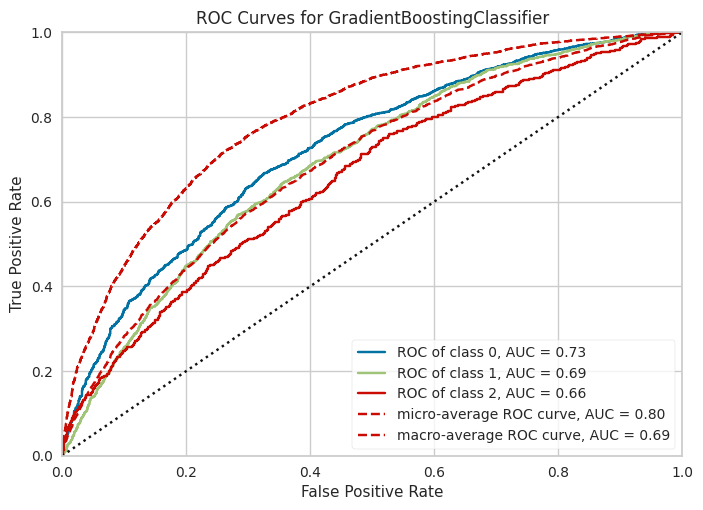

In [25]:
# check the residuals of trained model
plot_model(best, plot = 'auc')

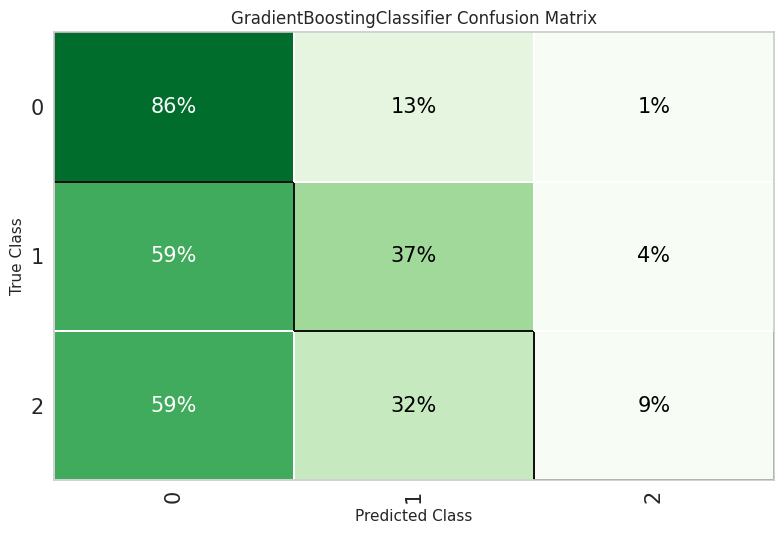

In [26]:
plot_model(best, plot = 'confusion_matrix', plot_kwargs = {'percent' : True})

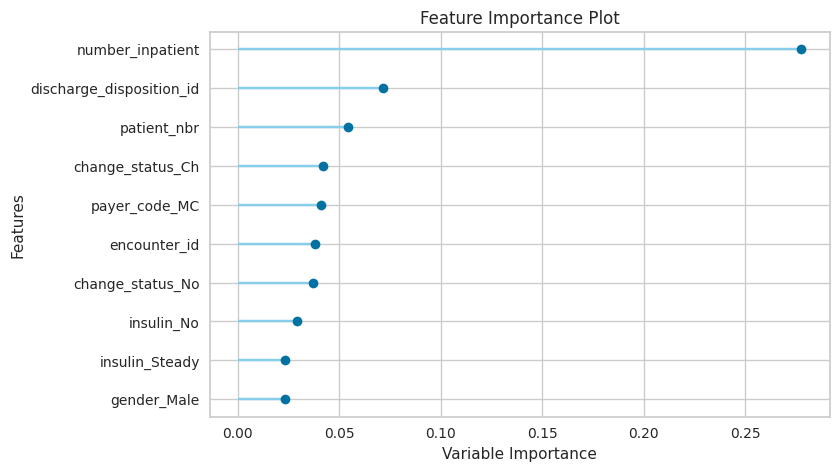

In [27]:
plot_model(best, plot = 'feature')

In [29]:
print(best)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='log_loss', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_samples_leaf=1,
                           min_samples_split=2, min_weight_fraction_leaf=0.0,
                           n_estimators=100, n_iter_no_change=None,
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6177,0.7107,0.6177,0.5846,0.5773,0.2384,0.2524
1,0.6120,0.6742,0.6120,0.5875,0.5743,0.2280,0.2412
2,0.6254,0.7056,0.6254,0.5933,0.5876,0.2552,0.2690
3,0.6120,0.6914,0.6120,0.5642,0.5675,0.2228,0.2368
4,0.6149,0.7014,0.6149,0.5943,0.5789,0.2317,0.2462
5,0.5929,0.6722,0.5929,0.5532,0.5534,0.1892,0.2003
6,0.5834,0.6697,0.5834,0.5439,0.5440,0.1729,0.1819
7,0.6101,0.6908,0.6101,0.5647,0.5674,0.2210,0.2346
8,0.6021,0.6799,0.6021,0.5513,0.5547,0.1963,0.2127


2023/05/28 21:12:08 WARNING mlflow.utils: Truncated the value of the key `estimator`. Truncated value: `Pipeline(memory=FastMemory(location=/tmp/joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['encounter_id', 'patient_nbr',
                                             'admission_type_id',
                                             'discharge_disposition_id',
                                             'admission_source_id',
                                             'time_in_hospital',
           ...`
2023/05/28 21:12:08 WARNING mlflow.utils: Truncated the value of the key `param_distributions`. Truncated value: `{'actual_estimator__n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300], 'actual_estimator__learning_rate': [1e-07, 1e-06, 0.0001, 0.001, 0.01, 0.0005, 0.005, 0.05, 0.1, 0.15,

Fitting 10 folds for each of 10 candidates, totalling 100 fits


2023/05/28 21:24:47 WARNING mlflow.sklearn.utils: Failed to autolog metrics for RandomizedSearchCV. Logging error: This RandomizedSearchCV instance was initialized with `refit=False`. predict is available only after refitting on the best parameters. You can refit an estimator manually using the `best_params_` attribute
2023/05/28 21:24:48 WARNING mlflow.sklearn.utils: _get_classifier_artifacts.<locals>.plot_confusion_matrix failed. The artifact training_confusion_matrix will not be recorded. Artifact error: This RandomizedSearchCV instance was initialized with `refit=False`. predict is available only after refitting on the best parameters. You can refit an estimator manually using the `best_params_` attribute
2023/05/28 21:24:48 WARNING mlflow.sklearn.utils: BaseSearchCV.score failed. The 'training_score' metric will not be recorded. Scoring error: This RandomizedSearchCV instance was initialized with `refit=False`. score is available only after refitting on the best parameters. You ca

2023/05/28 21:25:02 WARNING mlflow.utils: Truncated the value of the key `numerical_imputer__include`. Truncated value: `['encounter_id', 'patient_nbr', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'race_AfricanAmerican', 'race_Asian', 'race_Caucasian', 'race_Hispanic', 'race_Other', 'gender_Female', 'gender_Male', 'age_[0-10)', 'age_[10-20)', 'age_[20-30)', 'age_[30-40)', 'age_[40-50)', 'age_[50-60)', 'age_[60-70)', 'age_[70-8...`
2023/05/28 21:25:02 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('numerical_imputer', TransformerWrapper(exclude=None,
                   include=['encounter_id', 'patient_nbr', 'admission_type_id',
                            'discharge_disposition_id', 'admission_source_id',
                            'time_in_hospital', 'num_lab_proce

Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

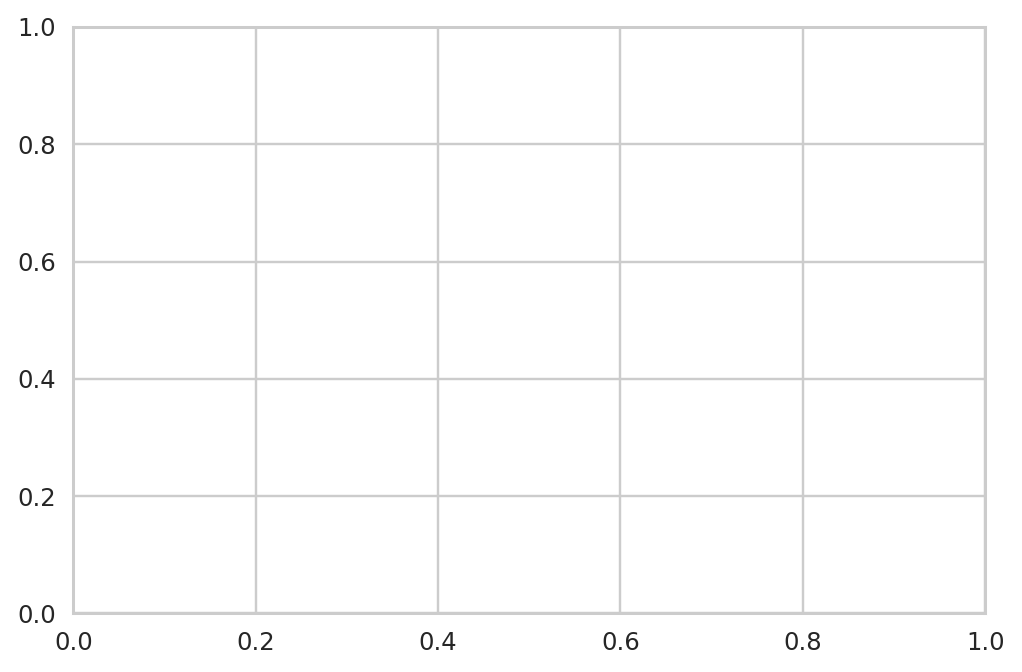

In [30]:
ft_best = pyc.tune_model(best)

In [31]:
print(ft_best)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='log_loss', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_samples_leaf=1,
                           min_samples_split=2, min_weight_fraction_leaf=0.0,
                           n_estimators=100, n_iter_no_change=None,
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


In [34]:
evaluate_model(ft_best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [35]:
predict_model(ft_best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.6167,0.7083,0.6167,0.5801,0.5775,0.2358,0.2514


,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,...,metformin_rosiglitazone_No,metformin_pioglitazone_No,metformin_pioglitazone_Steady,change_status_Ch,change_status_No,diabetesMed_No,diabetesMed_Yes,readmitted,prediction_label,prediction_score
27731,128535066,88972605,2,1,1,4,77,0,13,1,...,1,1,0,1,0,0,1,0,1,0.4834
15042,137668926,100793484,2,1,7,4,31,0,8,0,...,1,1,0,0,1,0,1,1,0,0.4714
29478,360738518,138654482,2,1,7,1,9,0,2,0,...,1,1,0,0,1,1,0,0,0,0.7741
19271,285672936,41903838,3,1,1,5,26,0,13,0,...,1,1,0,0,1,1,0,0,0,0.6903
25028,193231314,60194610,3,1,1,6,45,2,28,0,...,1,1,0,0,1,0,1,0,0,0.6011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32842,145776924,24523542,3,1,1,2,29,0,9,0,...,1,1,0,0,1,0,1,0,0,0.6614
54611,161023944,102348036,3,1,1,7,54,6,24,0,...,1,1,0,0,1,0,1,0,0,0.4585
29984,90248796,23419566,1,1,17,1,9,0,11,1,...,1,1,0,1,0,0,1,1,1,0.4042
39794,311435846,164151329,3,1,1,1,27,6,17,0,...,1,1,0,1,0,0,1,0,0,0.5841


In [36]:
final_best = save_model(ft_best , 'best_model')

Transformation Pipeline and Model Successfully Saved


In [37]:
final_best

(Pipeline(memory=FastMemory(location=/tmp/joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['encounter_id', 'patient_nbr',
                                              'admission_type_id',
                                              'discharge_disposition_id',
                                              'admission_source_id',
                                              'time_in_hospital',
                                              'num_lab_procedures',
                                              'num_procedures',
                                              'num_medications',
                                              'number_outpatient',
                                              'number_emergency',
                                              'number_inpatient',
                                              '...
                                             criterion='fri

In [35]:
modelo_inferencia = pyc.load_model('best_model')

Transformation Pipeline and Model Successfully Loaded


In [43]:
df_infer.to_csv('inferencia.csv')

In [38]:
df_infer['readmitted']

100    1
Name: readmitted, dtype: int64

In [41]:
prediccion = pyc.predict_model(modelo_inferencia, data = df_infer)
prediccion[['readmitted','prediction_label']]

,readmitted,prediction_label
100,1,0
